In [48]:
import pandas as pd

In [49]:
full_df = pd.read_feather('../data/data.feather')

<Axes: >

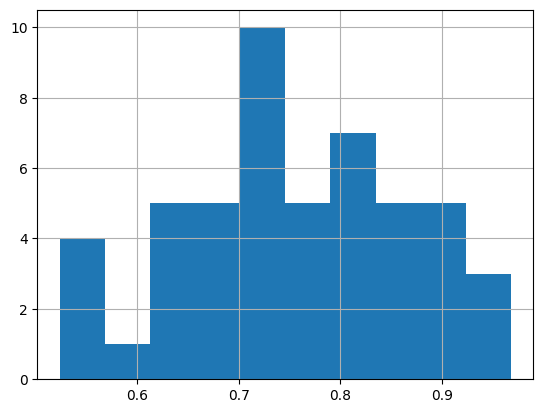

In [50]:
p_df = full_df.filter(regex="^p_")
p_df.isna().mean().hist()

In [51]:
df = p_df.loc[:, lambda x: x.isna().mean() < 0.65]

In [52]:
q_df = full_df.filter(regex='^q\d+')
dummies_df = pd.get_dummies(q_df, dummy_na=False)
dummies_df.shape

(68371, 7338)

In [53]:
from sklearn.decomposition import TruncatedSVD

svd = TruncatedSVD(n_components=20)
latent_features = svd.fit_transform(dummies_df)

In [54]:
latent_features.shape

(68371, 20)

In [55]:
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
from tqdm import tqdm

latent_df = pd.DataFrame(latent_features)

imputed_df = df.copy()

# for each col we predict the missing values from the SVD features above. 

for col in tqdm(df.columns):
    mask_not_null = df[col].notna()
    if mask_not_null.sum() > 100:
        X_train, X_test, y_train, y_test = train_test_split(
            latent_df.loc[mask_not_null], df.loc[mask_not_null, col], test_size=0.2)
        model = xgb.XGBRegressor(n_estimators=100, learning_rate=0.05)
        model.fit(X_train, y_train)
        mask_null = df[col].isna()
        imputed_df.loc[mask_null, col] = model.predict(latent_df.loc[mask_null])

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:06<00:00,  1.57it/s]


## clustering

### HDBSCAN without dim reduction:

In [56]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score, silhouette_samples

kmeans = KMeans(n_clusters=20, random_state=42)
cluster_labels = kmeans.fit_predict(imputed_df)

In [57]:
# silhouette scores
silhouette_avg = silhouette_score(imputed_df, cluster_labels)
sample_silhouette_values = silhouette_samples(imputed_df, cluster_labels)

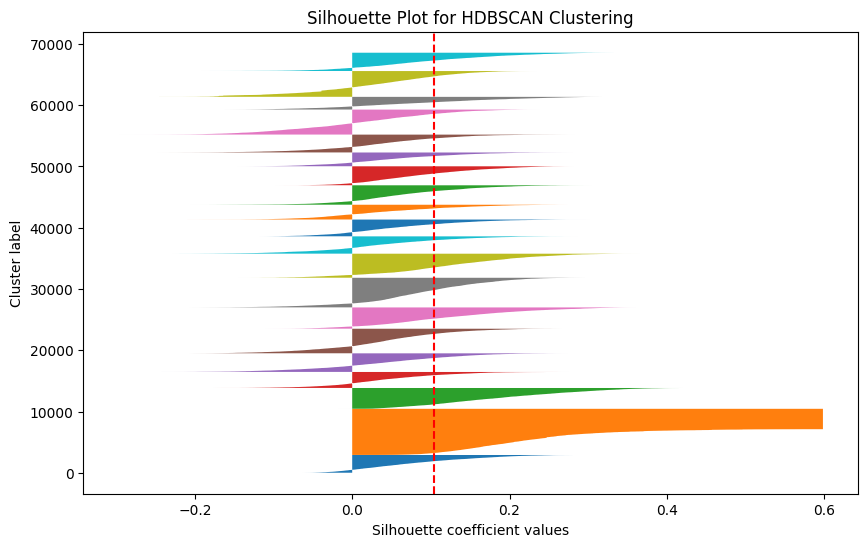

In [58]:
import numpy as np

# silhouette chart plot
plt.figure(figsize=(10, 6))
y_lower = 10
for i in range(max(cluster_labels) + 1):
    ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
    ith_cluster_silhouette_values.sort()
    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i
    plt.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values)
    y_lower = y_upper + 10

plt.title("Silhouette Plot for HDBSCAN Clustering")
plt.xlabel("Silhouette coefficient values")
plt.ylabel("Cluster label")
plt.axvline(x=silhouette_avg, color="red", linestyle="--")
plt.show()

### clustering on latent_features?

In [43]:
from sklearn.cluster import HDBSCAN
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score, silhouette_samples

clusterer = HDBSCAN(min_cluster_size=5, min_samples=5)
cluster_labels = clusterer.fit_predict(latent_features)

In [44]:
silhouette_avg_latent = silhouette_score(latent_features, cluster_labels)
sample_silhouette_values_latent = silhouette_samples(latent_features, cluster_labels)

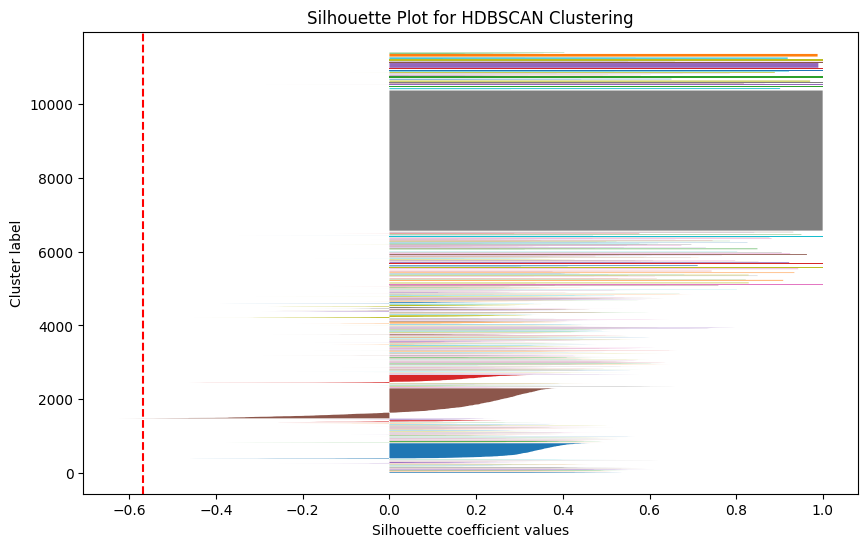

In [45]:
import numpy as np

# silhouette chart plot
plt.figure(figsize=(10, 6))
y_lower = 10
for i in range(max(cluster_labels) + 1):
    ith_cluster_silhouette_values = sample_silhouette_values_latent[cluster_labels == i]
    ith_cluster_silhouette_values.sort()
    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i
    plt.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values)
    y_lower = y_upper + 10

plt.title("Silhouette Plot for HDBSCAN Clustering")
plt.xlabel("Silhouette coefficient values")
plt.ylabel("Cluster label")
plt.axvline(x=silhouette_avg_latent, color="red", linestyle="--")
plt.show()

### clustering with dim reduction first

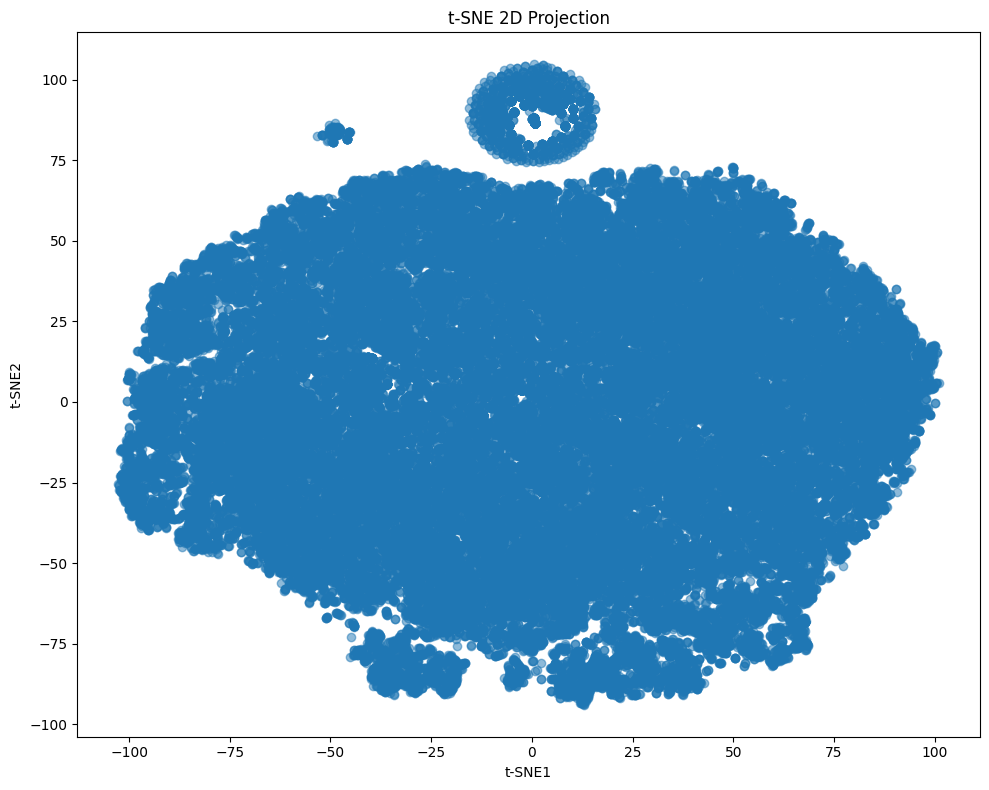

In [36]:
import pandas as pd
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Assuming imputed_df is your DataFrame with the data
X = imputed_df.values

# Apply t-SNE
tsne = TSNE(n_components=2, random_state=42)
X_2d = tsne.fit_transform(X)

# Plot the results
plt.figure(figsize=(10, 8))
plt.scatter(X_2d[:, 0], X_2d[:, 1], alpha=0.5)
plt.title('t-SNE 2D Projection')
plt.xlabel('t-SNE1')
plt.ylabel('t-SNE2')
plt.tight_layout()
plt.show()

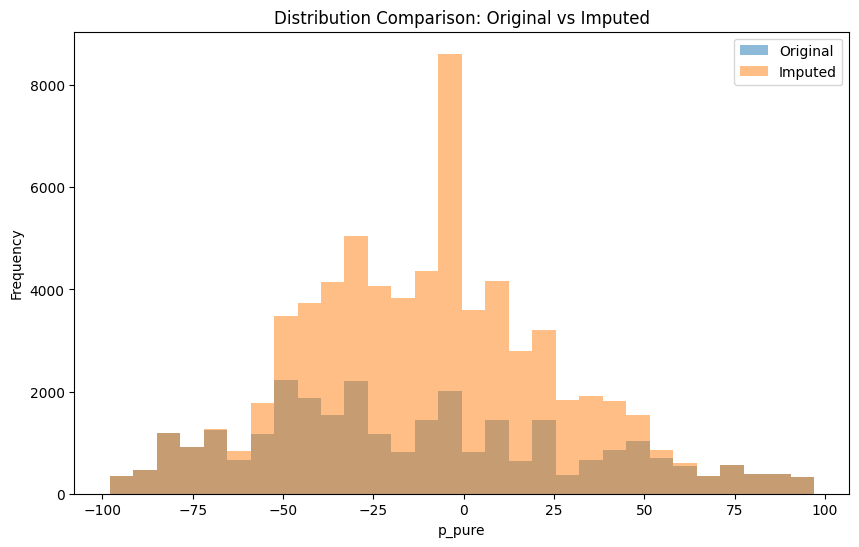

In [40]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.hist(p_df['p_pure'], bins=30, alpha=0.5, label='Original')
plt.hist(imputed_df['p_pure'], bins=30, alpha=0.5, label='Imputed')
plt.legend()
plt.title('Distribution Comparison: Original vs Imputed')
plt.xlabel('p_pure')
plt.ylabel('Frequency')
plt.show()